Como forma de ganhar tempo para focar em decisões metodológicas mais significativas, LLMs serão empregadas para gerar plots.

### Leitura das métricas logadas

In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path
from tensorboard.backend.event_processing import event_accumulator
from pprint import pprint
import matplotlib.pyplot as plt
import polars as pl


ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))
from src.constants import NUM_ROUND_DIGITS  # noqa: E402


RESULTS_DIR = Path.cwd().parent / 'results'

#### Fase 1

In [2]:
# Carregar os dados dos logs do TensorBoard
def load_events_data(log_dir: str):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Acessar os dados de scalars (loss, accuracy, etc.)
    tags = ea.Tags()['scalars']

    # Criar um dataframe vazio para armazenar os dados
    data_train = {}
    data_test = {}
    data_times = {}

    # Iterar sobre as tags e extrair os valores
    for tag in tags:
        if 'step' not in tag and tag != 'epoch':
            # Como estou desconsiderando o métricas a nível de step, 
            # os resultados não precisam de ordenamento ao longo do tempo        
            events = ea.Scalars(tag)
            if 'time' in tag:
                time = events[0].value
                data_times[tag] = time

                continue
                
            for event in events:
                step = event.step  # ignorado, a nível de época
                value = event.value
                if 'train' in tag:
                    if not data_train.get(tag):
                        data_train[tag] = []
                    data_train[tag].append(value)
                elif 'test' in tag:
                    if not data_test.get(tag):
                        data_test[tag] = []
                    data_test[tag].append(value)



    # Mostrar o DataFrame's
    df_train = pl.DataFrame(data_train)
    df_test = pl.DataFrame(data_test)
    data_times = pl.DataFrame(data_times)
    
    return df_train, df_test, data_times

    # # Salvar o DataFrame como CSV (se necessário)
    # df.write_csv(RESULTS_DIR/f"phase_1/csvs/tensorboard_data_polars_{'_'.join(log_dir.split(os.path.sep)[-3:])}.csv")
    # print(df)

In [3]:
#          model | repet | kfolditer | metric x | metric y | ...
#                                       value1  |  value1  | ...
#                                       value2  |  value2  | ...
#                                       value3  |  value3  | ...
#                                       value4  |  value4  | ...
#                                       value5  |  value5  | ...
df_list_train = []
df_list_test = []
df_list_times = []


for events_dir in RESULTS_DIR.glob('phase_1/tb_logs/*/repet*/kfolditer*'):
    repet = int(events_dir.parents[0].name[-1])
    model = events_dir.parents[1].name
    kfolditer = int(events_dir.name[-1])

    # carrega os datos de uma iteração do kfold
    df_train, df_test, df_times = load_events_data(str(events_dir))

    # Organização dos dados
    # treino
    df_train = df_train.with_columns([
        pl.lit(model).alias('model'),
        pl.lit(repet).alias('repet'),
        pl.lit(kfolditer).alias('kfolditer'),
    ])

    # teste
    df_test = df_test.with_columns([
        pl.lit(model).alias('model'),
        pl.lit(repet).alias('repet'),
        pl.lit(kfolditer).alias('kfolditer'),
    ])

    # times
    df_times = df_times.with_columns([
        pl.lit(model).alias('model'),
        pl.lit(repet).alias('repet'),
        pl.lit(kfolditer).alias('kfolditer'),
    ])


    df_list_train.append(df_train)
    df_list_test.append(df_test)
    df_list_times.append(df_times)


df_train: pl.DataFrame = pl.concat(df_list_train)
df_test: pl.DataFrame = pl.concat(df_list_test)
df_times: pl.DataFrame = pl.concat(df_list_times)

In [193]:
df_train.write_csv(RESULTS_DIR / 'phase_1/csvs/train_epoch_results.csv')
df_test.write_csv(RESULTS_DIR / 'phase_1/csvs/test_epoch_results.csv')
df_test.write_csv(RESULTS_DIR / 'phase_1/csvs/times_results.csv')

### Distribuição

In [194]:
df_test

epoch_test_per_image_iou,epoch_test_dataset_iou,epoch_test_per_image_sensitivity,epoch_test_dataset_sensitivity,epoch_test_per_image_specificity,epoch_test_dataset_specificity,epoch_test_per_image_f1,epoch_test_dataset_f1,epoch_avg_loss_test,model,repet,kfolditer
f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i32
0.311821,0.964655,0.317192,0.978925,0.329266,0.994508,0.317538,0.981943,0.017907,"""deeplabv3+_256x256_pngs_prepro…",3,0
0.301495,0.95434,0.313993,0.975734,0.329262,0.995231,0.307346,0.976514,0.026368,"""deeplabv3+_256x256_pngs_prepro…",3,2
0.301112,0.938536,0.309229,0.962461,0.328781,0.993065,0.308547,0.968069,0.035667,"""deeplabv3+_256x256_pngs_prepro…",3,4
0.304892,0.950362,0.312934,0.96991,0.329072,0.993769,0.310918,0.974409,0.02665,"""deeplabv3+_256x256_pngs_prepro…",3,3
0.300347,0.916758,0.312397,0.954581,0.328989,0.993457,0.307038,0.956139,0.037651,"""deeplabv3+_256x256_pngs_prepro…",3,1
…,…,…,…,…,…,…,…,…,…,…,…
0.303163,0.946204,0.313347,0.97169,0.329404,0.994145,0.309885,0.972195,0.027134,"""segformer_256x256_pngs_preproc""",1,0
0.306526,0.949544,0.313097,0.967873,0.329099,0.99388,0.312414,0.973968,0.028361,"""segformer_256x256_pngs_preproc""",1,2
0.301483,0.94316,0.30778,0.962487,0.328274,0.992835,0.308741,0.97056,0.031077,"""segformer_256x256_pngs_preproc""",1,4


### Médias Gerais


In [195]:
df_test

epoch_test_per_image_iou,epoch_test_dataset_iou,epoch_test_per_image_sensitivity,epoch_test_dataset_sensitivity,epoch_test_per_image_specificity,epoch_test_dataset_specificity,epoch_test_per_image_f1,epoch_test_dataset_f1,epoch_avg_loss_test,model,repet,kfolditer
f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i32
0.311821,0.964655,0.317192,0.978925,0.329266,0.994508,0.317538,0.981943,0.017907,"""deeplabv3+_256x256_pngs_prepro…",3,0
0.301495,0.95434,0.313993,0.975734,0.329262,0.995231,0.307346,0.976514,0.026368,"""deeplabv3+_256x256_pngs_prepro…",3,2
0.301112,0.938536,0.309229,0.962461,0.328781,0.993065,0.308547,0.968069,0.035667,"""deeplabv3+_256x256_pngs_prepro…",3,4
0.304892,0.950362,0.312934,0.96991,0.329072,0.993769,0.310918,0.974409,0.02665,"""deeplabv3+_256x256_pngs_prepro…",3,3
0.300347,0.916758,0.312397,0.954581,0.328989,0.993457,0.307038,0.956139,0.037651,"""deeplabv3+_256x256_pngs_prepro…",3,1
…,…,…,…,…,…,…,…,…,…,…,…
0.303163,0.946204,0.313347,0.97169,0.329404,0.994145,0.309885,0.972195,0.027134,"""segformer_256x256_pngs_preproc""",1,0
0.306526,0.949544,0.313097,0.967873,0.329099,0.99388,0.312414,0.973968,0.028361,"""segformer_256x256_pngs_preproc""",1,2
0.301483,0.94316,0.30778,0.962487,0.328274,0.992835,0.308741,0.97056,0.031077,"""segformer_256x256_pngs_preproc""",1,4


In [196]:
# treino
geral_mean_df = (
    df_test.group_by('model')
    .agg([pl.col(c).mean() for c in df_test.columns if 'epoch' in c])
)

In [197]:
geral_mean_df

model,epoch_test_per_image_iou,epoch_test_dataset_iou,epoch_test_per_image_sensitivity,epoch_test_dataset_sensitivity,epoch_test_per_image_specificity,epoch_test_dataset_specificity,epoch_test_per_image_f1,epoch_test_dataset_f1,epoch_avg_loss_test
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""segformer_256x256_pngs_preproc""",0.301829,0.935903,0.311593,0.964046,0.329088,0.994057,0.308052,0.966352,0.03195
"""deeplabv3+_256x256_pngs_prepro…",0.303969,0.945435,0.313162,0.968914,0.329077,0.994031,0.310359,0.971685,0.02848
"""unet++_256x256_pngs_preproc""",0.301475,0.932686,0.312106,0.962943,0.329959,0.994726,0.307032,0.964466,0.035108
"""dpt_256x256_pngs_preproc""",0.303055,0.93582,0.311958,0.963648,0.329209,0.993936,0.309033,0.96629,0.03267


/tmp/ipykernel_3032790/1403074483.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")
/tmp/ipykernel_3032790/1403074483.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")
/tmp/ipykernel_3032790/1403074483.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")


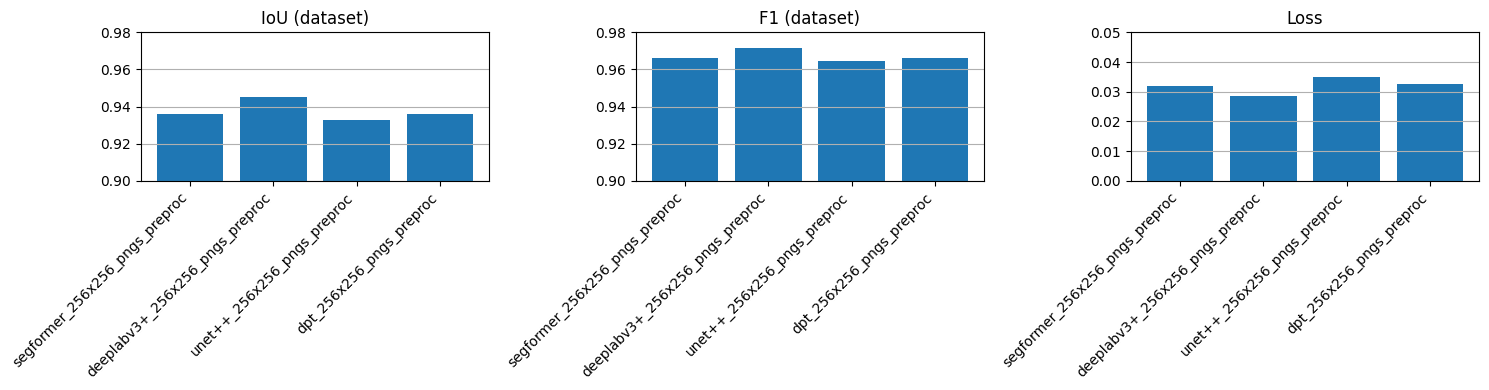

In [198]:
metrics = {
    "IoU (dataset)": "epoch_test_dataset_iou",
    "F1 (dataset)": "epoch_test_dataset_f1",
    "Loss": "epoch_avg_loss_test",
}

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, (title, col) in zip(axs, metrics.items()):
    ax.set_ylim(0.90, 0.98)
    if title=='Loss':
        ax.set_ylim(0, 0.05)

    ax.bar(geral_mean_df["model"], geral_mean_df[col])
    ax.set_title(title)
    ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")
    ax.grid(True, axis="y")

plt.tight_layout()
plt.show()

### Tempo de treinamento e teste

In [207]:
df_times_agrupado = (
    df_times
    .group_by('model')
    .agg([
        (pl.col('training_time')/60).mean().round(NUM_ROUND_DIGITS).alias('mean_training_time'),
        (pl.col('training_time')/60).std().round(NUM_ROUND_DIGITS).alias('std_training_time'),

        pl.col('test_time').mean().round(NUM_ROUND_DIGITS).alias('mean_test_time'),
        pl.col('test_time').std().round(NUM_ROUND_DIGITS).alias('std_test_time'),
    ])

)

df_times_agrupado.write_csv(RESULTS_DIR/'phase_1/csvs/train_and_test_time.csv')

In [259]:
# Paleta
df_models_fmt = df_times_agrupado.map_columns('model', lambda c: c.map_elements(lambda e: e.split('_')[0]))  # apenas ajustando o nome dos modelos
unique_models = ['dpt', 'deeplabv3+', 'unet++', 'segformer']
palette_dict = {model: color for model, color in zip(unique_models, sns.color_palette("Set2", n_colors=len(unique_models)))}

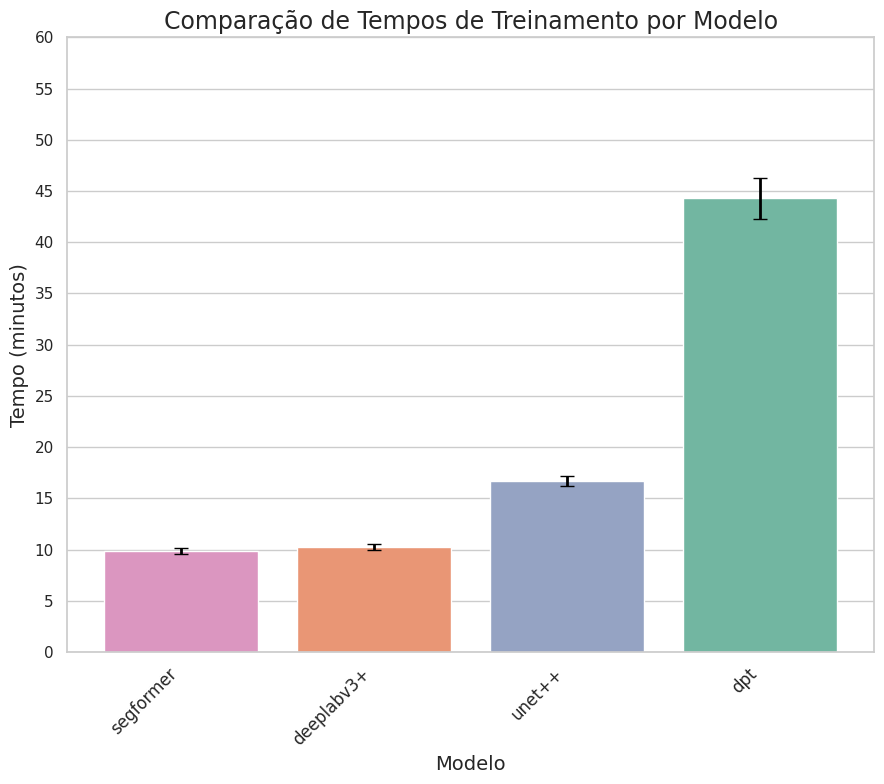

In [262]:
# Criando o gráfico
df = df_models_fmt.sort('mean_training_time')
fig = plt.figure(figsize=(9, 8))
sns.set_theme(style="whitegrid")

# Criando o gráfico de barras com seaborn
ax = sns.barplot(x='model', 
                 y='mean_training_time', 
                 hue='model', 
                 data=df, 
                 palette=palette_dict, 
                 errorbar=None)  # Desabilitando o intervalo de confiança padrão

# Adicionando as barras de erro manualmente com ax.errorbar
ax.errorbar(x=range(len(df['model'])),
            y=df['mean_training_time'],
            yerr=df['std_training_time'],
            fmt='none',  # Sem marcação, apenas as barras de erro
            color='black',  # Cor das barras de erro
            capsize=5,  # Capacidade das barras de erro
            elinewidth=2,  # Largura das barras de erro
            errorevery=1,  # Mostra uma barra de erro para cada ponto
            label="Desvio Padrão")

# Adicionando título e rótulos
plt.title('Comparação de Tempos de Treinamento por Modelo', fontsize=17)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Tempo (minutos)', fontsize=14)

# Ajustando o gráfico para melhorar a visualização
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(ticks=list(range(0, 61, 5)))
plt.tight_layout()

# Exibindo o gráfico
plt.show()

#Salvando
fig.savefig(RESULTS_DIR/"phase_1/figs/train_time.png", dpi=250)


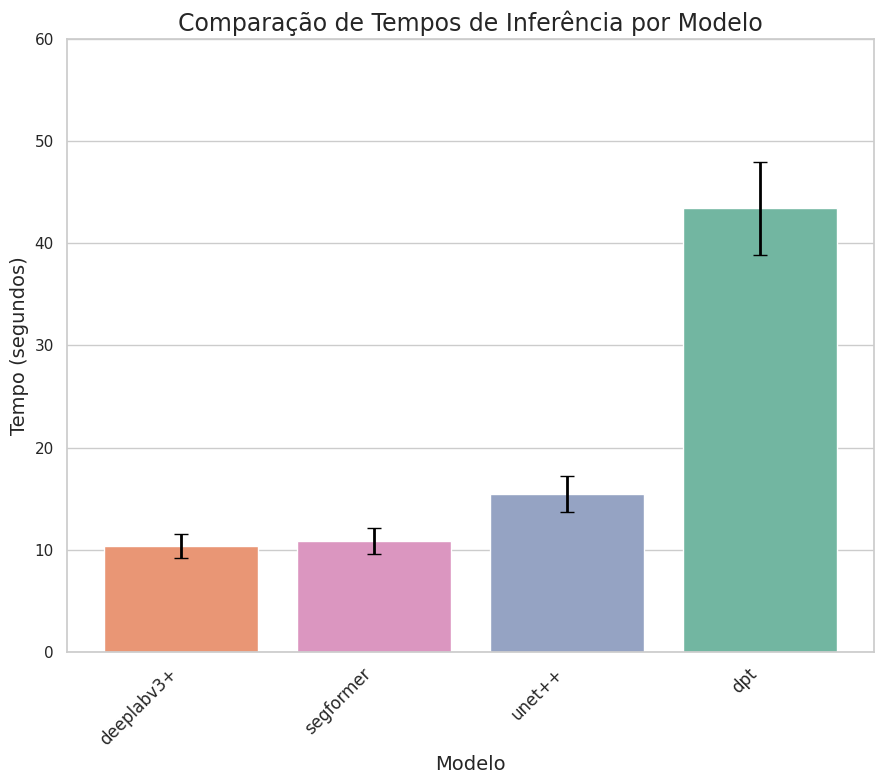

In [263]:
# Criando o gráfico
df = df_models_fmt.sort('mean_test_time')
fig = plt.figure(figsize=(9, 8))
sns.set_theme(style="whitegrid")

# Criando o gráfico de barras com seaborn
ax = sns.barplot(x='model', 
                 y='mean_test_time', 
                 hue='model', 
                 data=df, 
                 palette=palette_dict, 
                 errorbar=None)  # Desabilitando o intervalo de confiança padrão

# Adicionando as barras de erro manualmente com ax.errorbar
ax.errorbar(x=range(len(df['model'])),
            y=df['mean_test_time'],
            yerr=df['std_test_time'],
            fmt='none',  # Sem marcação, apenas as barras de erro
            color='black',  # Cor das barras de erro
            capsize=5,  # Capacidade das barras de erro
            elinewidth=2,  # Largura das barras de erro
            errorevery=1,  # Mostra uma barra de erro para cada ponto
            label="Desvio Padrão")

# Adicionando título e rótulos
plt.title('Comparação de Tempos de Inferência por Modelo', fontsize=17)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Tempo (segundos)', fontsize=14)

# Ajustando o gráfico para melhorar a visualização
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(ticks=list(range(0, 61, 10)))
plt.tight_layout()

# Exibindo o gráfico
plt.show()

# Salvando
fig.savefig(RESULTS_DIR/"phase_1/figs/test_time.png", dpi=250)


### Mediana

/tmp/ipykernel_2013292/844988596.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_median_df["model"], rotation=45, ha="right")
/tmp/ipykernel_2013292/844988596.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_median_df["model"], rotation=45, ha="right")
/tmp/ipykernel_2013292/844988596.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_median_df["model"], rotation=45, ha="right")


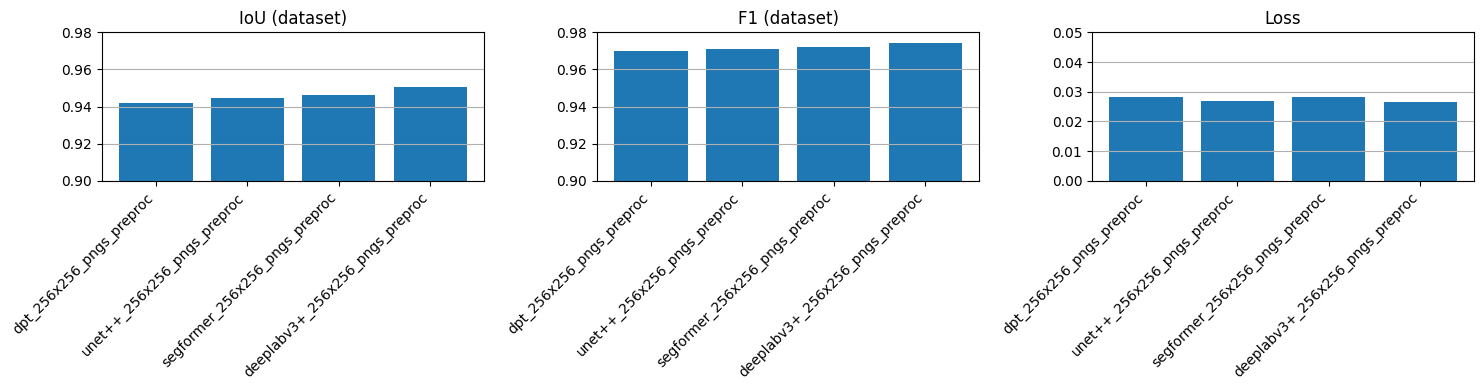

In [134]:
# treino
geral_median_df = (
    df_test.group_by('model')
    .agg([pl.col(c).median() for c in df_test.columns if 'epoch' in c])
)


metrics = {
    "IoU (dataset)": "epoch_test_dataset_iou",
    "F1 (dataset)": "epoch_test_dataset_f1",
    "Loss": "epoch_avg_loss_test",
}

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, (title, col) in zip(axs, metrics.items()):
    ax.set_ylim(0.90, 0.98)
    if title=='Loss':
        ax.set_ylim(0, 0.05)

    ax.bar(geral_median_df["model"], geral_median_df[col])
    ax.set_title(title)
    ax.set_xticklabels(geral_median_df["model"], rotation=45, ha="right")
    ax.grid(True, axis="y")

plt.tight_layout()
plt.show()

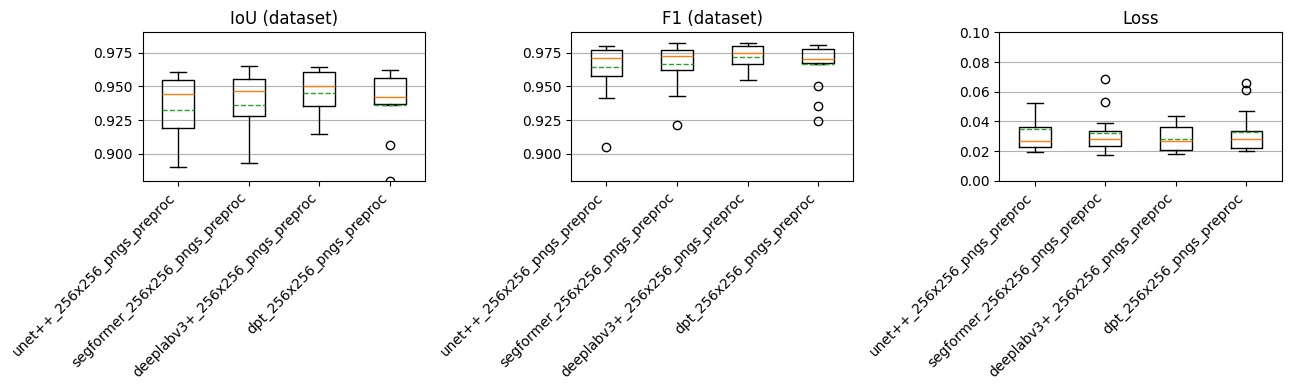

In [135]:
import matplotlib.pyplot as plt
import polars as pl

metrics = {
    "IoU (dataset)": "epoch_test_dataset_iou",
    "F1 (dataset)": "epoch_test_dataset_f1",
    "Loss": "epoch_avg_loss_test",
}

models = df_test["model"].unique().to_list()

fig, axs = plt.subplots(1, 3, figsize=(13, 4), dpi=100)

for ax, (title, col) in zip(axs, metrics.items()):
    data = [
        df_test.filter(pl.col("model") == m)[col].to_numpy()
        for m in models
    ]

    ax.boxplot(
        data,
        showmeans=True,
        meanline=True
    )

    ax.set_title(title)
    ax.set_xticks(range(1, len(models) + 1))
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.grid(True, axis="y")

    if title == "Loss":
        ax.set_ylim(0, 0.10)
    else:
        ax.set_ylim(0.88, 0.99)

plt.tight_layout()
plt.show()


### BoxPlots

In [ ]:
box_plot_cols = [col for col in df_test.columns if 'image' not in col]

In [ ]:
df = df_test.map_columns('model', lambda c: c.map_elements(lambda e: e.split('_')[0]))  # apenas ajustando o nome dos modelos

In [ ]:
box_plot_cols

['epoch_test_dataset_iou',
 'epoch_test_dataset_sensitivity',
 'epoch_test_dataset_specificity',
 'epoch_test_dataset_f1',
 'epoch_avg_loss_test',
 'model',
 'repet',
 'kfolditer']

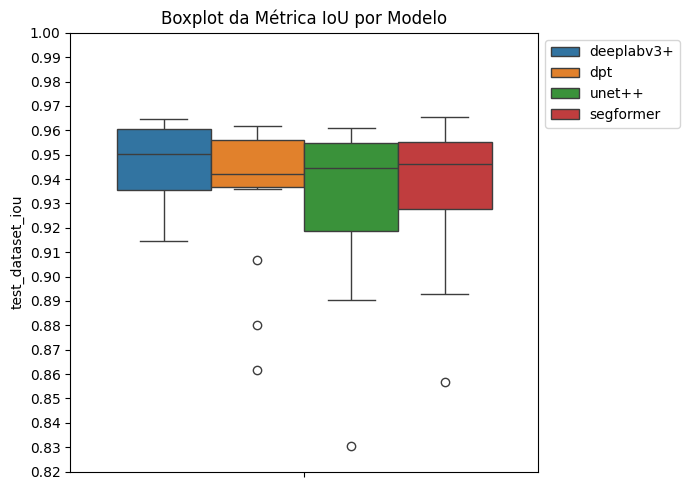

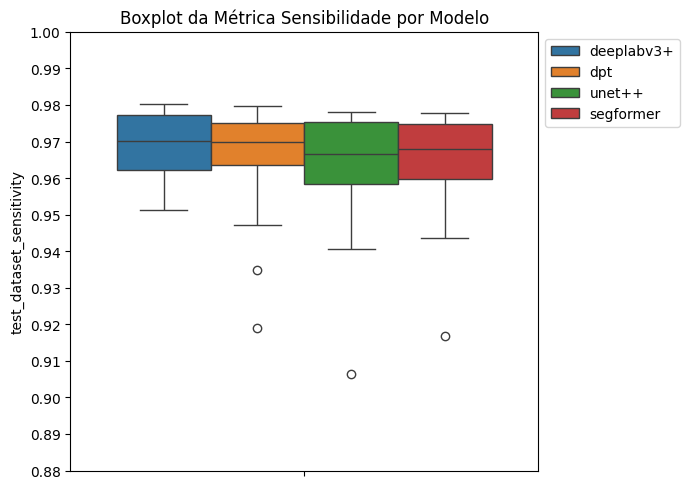

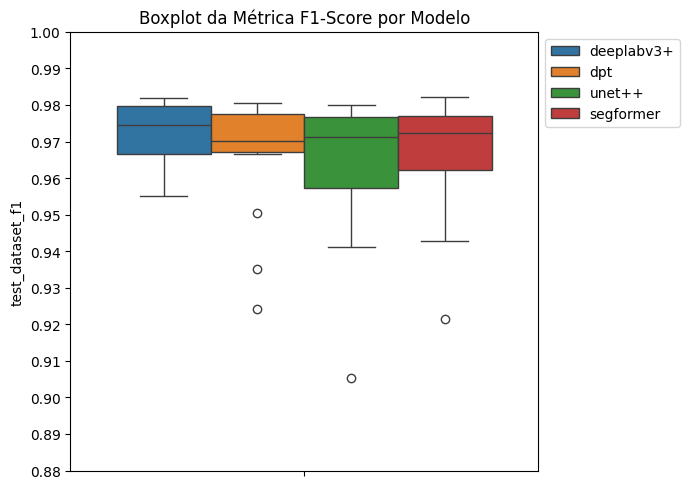

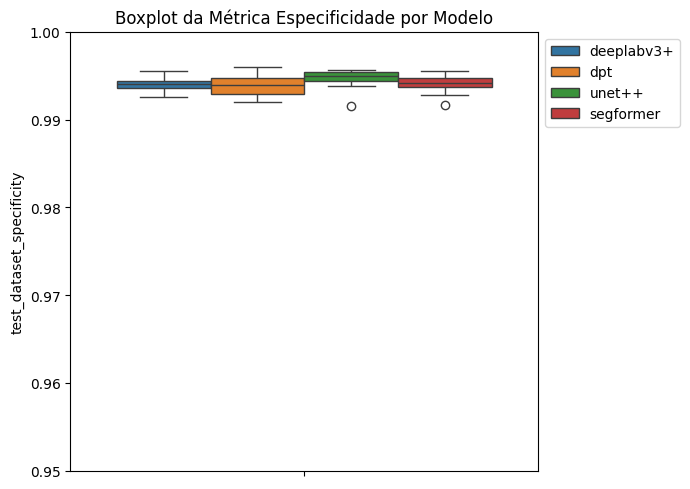

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Criando o boxplot
plt.figure(figsize=(7, 5), dpi=100)
sns.boxplot(y='epoch_test_dataset_iou', hue='model', data=df)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.ylabel('test_dataset_iou')

# Ajustando o gráfico
plt.yticks(np.arange(0.82, 1.001, 0.01))
plt.title("Boxplot da Métrica IoU por Modelo")
plt.tight_layout()
plt.show()


# Criando o boxplot
plt.figure(figsize=(7, 5), dpi=100)
sns.boxplot(y='epoch_test_dataset_sensitivity', hue='model', data=df)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.ylabel('test_dataset_sensitivity')

# Ajustando o gráfico
plt.yticks(np.arange(0.88, 1.001, 0.01))
plt.title("Boxplot da Métrica Sensibilidade por Modelo")
plt.tight_layout()
plt.show()


# Criando o boxplot
plt.figure(figsize=(7, 5), dpi=100)
sns.boxplot(y='epoch_test_dataset_f1', hue='model', data=df)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.ylabel('test_dataset_f1')

# Ajustando o gráfico
plt.yticks(np.arange(0.88, 1.001, 0.01))
plt.title("Boxplot da Métrica F1-Score por Modelo")
plt.tight_layout()
plt.show()


# Criando o boxplot
plt.figure(figsize=(7, 5), dpi=100)
sns.boxplot(y='epoch_test_dataset_specificity', hue='model', data=df)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.ylabel('test_dataset_specificity')

# Ajustando o gráfico
plt.yticks(np.arange(0.95, 1.001, 0.01))
plt.title("Boxplot da Métrica Especificidade por Modelo")
plt.tight_layout()
plt.show()




### Testes estatísticos

In [15]:
dados_teste_agrupados = (  # O propósito aqui é obter todas os resultados para cada modelo
    df_test
    .group_by('model')
    .agg([pl.col(c) for c in df_test.columns if 'epoch' in c])
)

In [16]:
dados_teste_agrupados

model,epoch_test_per_image_iou,epoch_test_dataset_iou,epoch_test_per_image_sensitivity,epoch_test_dataset_sensitivity,epoch_test_per_image_specificity,epoch_test_dataset_specificity,epoch_test_per_image_f1,epoch_test_dataset_f1,epoch_avg_loss_test
str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64]
"""unet++_256x256_pngs_preproc""","[0.313318, 0.306998, … 0.296419]","[0.94453, 0.960809, … 0.917055]","[0.320473, 0.318716, … 0.305558]","[0.966621, 0.975542, … 0.956019]","[0.330503, 0.330184, … 0.329773]","[0.994492, 0.995103, … 0.994925]","[0.31857, 0.312753, … 0.30203]","[0.971291, 0.97992, … 0.956286]","[0.02475, 0.020738, … 0.044984]"
"""dpt_256x256_pngs_preproc""","[0.30823, 0.296166, … 0.307076]","[0.957555, 0.861498, … 0.950596]","[0.315933, 0.305128, … 0.318167]","[0.975817, 0.919066, … 0.979708]","[0.329466, 0.328528, … 0.330007]","[0.99427, 0.992031, … 0.996039]","[0.314131, 0.30206, … 0.313046]","[0.97822, 0.924205, … 0.974533]","[0.022235, 0.06619, … 0.026465]"
"""deeplabv3+_256x256_pngs_prepro…","[0.311821, 0.301495, … 0.309084]","[0.964655, 0.95434, … 0.945033]","[0.317192, 0.313993, … 0.315697]","[0.978925, 0.975734, … 0.970054]","[0.329266, 0.329262, … 0.329085]","[0.994508, 0.995231, … 0.994173]","[0.317538, 0.307346, … 0.315489]","[0.981943, 0.976514, … 0.971565]","[0.017907, 0.026368, … 0.027467]"
"""segformer_256x256_pngs_preproc""","[0.303417, 0.305111, … 0.294876]","[0.959435, 0.950613, … 0.856708]","[0.318168, 0.315817, … 0.303276]","[0.977783, 0.975993, … 0.916825]","[0.329698, 0.329616, … 0.328054]","[0.994489, 0.995563, … 0.99167]","[0.309677, 0.311017, … 0.301947]","[0.97921, 0.974534, … 0.921366]","[0.021603, 0.028261, … 0.068558]"


In [ ]:
desempenho_medio_por_fold = (  # O objetivo aqui é ter a média das folds (em cada iteração do kfold ao longo de uma repetição, os dados são os mesmos de uma repetição anterior)
    df_test
    .group_by(['model', 'kfolditer'])  # Agrupando por kfolditer, assim tenho os valores das 3 repetições por fold
    .agg(
        [pl.col(c).mean().alias(f'mean_{c}') for c in df_test.columns if 'epoch' in c] + # Calculando a média das métricas de cada iteração
        [pl.col(c).std().alias(f'std_{c}') for c in df_test.columns if 'epoch' in c]
    )  
)

In [198]:
desempenho_medio_por_fold

model,kfolditer,mean_epoch_test_per_image_iou,mean_epoch_test_dataset_iou,mean_epoch_test_per_image_sensitivity,mean_epoch_test_dataset_sensitivity,mean_epoch_test_per_image_specificity,mean_epoch_test_dataset_specificity,mean_epoch_test_per_image_f1,mean_epoch_test_dataset_f1,mean_epoch_avg_loss_test,std_epoch_test_per_image_iou,std_epoch_test_dataset_iou,std_epoch_test_per_image_sensitivity,std_epoch_test_dataset_sensitivity,std_epoch_test_per_image_specificity,std_epoch_test_dataset_specificity,std_epoch_test_per_image_f1,std_epoch_test_dataset_f1,std_epoch_avg_loss_test
str,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""segformer_256x256_pngs_preproc""",4,0.304878,0.951904,0.311354,0.970217,0.328873,0.994015,0.311449,0.975213,0.025789,0.003103,0.007827,0.003154,0.006733,0.000521,0.001026,0.002545,0.004163,0.004655
"""dpt_256x256_pngs_preproc""",0,0.305092,0.946933,0.312656,0.967745,0.329257,0.993362,0.311305,0.972565,0.026975,0.004012,0.009213,0.003115,0.007128,0.000181,0.000824,0.003732,0.004905,0.004259
"""segformer_256x256_pngs_preproc""",0,0.304654,0.953855,0.315427,0.975089,0.329599,0.994439,0.31092,0.976255,0.024087,0.002366,0.006854,0.002477,0.003107,0.000169,0.000273,0.001976,0.003636,0.002808
"""unet++_256x256_pngs_preproc""",0,0.308236,0.942243,0.315911,0.966279,0.330155,0.99434,0.313728,0.970061,0.026984,0.004407,0.003101,0.003953,0.000591,0.000358,0.000197,0.004196,0.001668,0.001955
"""unet++_256x256_pngs_preproc""",3,0.297468,0.921608,0.308855,0.959556,0.32979,0.994698,0.302678,0.95857,0.0362,0.006543,0.03157,0.00811,0.018697,0.000447,0.000898,0.006955,0.017439,0.015194
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""unet++_256x256_pngs_preproc""",1,0.301085,0.926659,0.311355,0.961809,0.330061,0.995228,0.306537,0.961514,0.035794,0.005119,0.018224,0.005023,0.009253,0.000319,0.000304,0.004942,0.009936,0.01019
"""unet++_256x256_pngs_preproc""",4,0.295646,0.914658,0.306977,0.95115,0.329468,0.993895,0.302093,0.953608,0.054766,0.017931,0.073091,0.012463,0.038828,0.000511,0.002025,0.016127,0.041963,0.05479
"""segformer_256x256_pngs_preproc""",1,0.296368,0.888755,0.308731,0.939848,0.32893,0.993297,0.303194,0.940034,0.053679,0.003966,0.030166,0.005017,0.021363,0.000837,0.001575,0.003278,0.017491,0.014712


In [191]:
desempenho_medio_modelos = (desempenho_medio_por_fold.group_by(['model'])
    .agg([pl.col(c) for c in desempenho_medio_por_fold.columns if 'mean_epoch' in c])
)

In [194]:
desempenho_medio_modelos.sort(by='model', maintain_order=True)  # mantem a ordem pra facilitar comparações

model,mean_epoch_test_per_image_iou,mean_epoch_test_dataset_iou,mean_epoch_test_per_image_sensitivity,mean_epoch_test_dataset_sensitivity,mean_epoch_test_per_image_specificity,mean_epoch_test_dataset_specificity,mean_epoch_test_per_image_f1,mean_epoch_test_dataset_f1,mean_epoch_avg_loss_test
str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64]
"""deeplabv3+_256x256_pngs_prepro…","[0.303914, 0.305106, … 0.310359]","[0.925473, 0.954223, … 0.963575]","[0.312975, 0.314005, … 0.317559]","[0.958675, 0.972734, … 0.978769]","[0.328761, 0.32914, … 0.329506]","[0.993406, 0.99406, … 0.994465]","[0.310893, 0.310982, … 0.316169]","[0.960887, 0.976452, … 0.981378]","[0.034022, 0.023112, … 0.018494]"
"""dpt_256x256_pngs_preproc""","[0.303678, 0.299094, … 0.305092]","[0.943877, 0.918783, … 0.946933]","[0.312943, 0.310142, … 0.312656]","[0.971085, 0.953893, … 0.967745]","[0.329525, 0.329119, … 0.329257]","[0.994908, 0.993733, … 0.993362]","[0.309008, 0.304959, … 0.311305]","[0.970921, 0.956595, … 0.972565]","[0.026434, 0.041374, … 0.026975]"
"""segformer_256x256_pngs_preproc""","[0.296998, 0.304878, … 0.296368]","[0.929855, 0.951904, … 0.888755]","[0.307497, 0.311354, … 0.308731]","[0.962234, 0.970217, … 0.939848]","[0.328859, 0.328873, … 0.32893]","[0.994135, 0.994015, … 0.993297]","[0.302549, 0.311449, … 0.303194]","[0.96334, 0.975213, … 0.940034]","[0.031615, 0.025789, … 0.053679]"
"""unet++_256x256_pngs_preproc""","[0.308236, 0.295646, … 0.297468]","[0.942243, 0.914658, … 0.921608]","[0.315911, 0.306977, … 0.308855]","[0.966279, 0.95115, … 0.959556]","[0.330155, 0.329468, … 0.32979]","[0.99434, 0.993895, … 0.994698]","[0.313728, 0.302093, … 0.302678]","[0.970061, 0.953608, … 0.95857]","[0.026984, 0.054766, … 0.0362]"


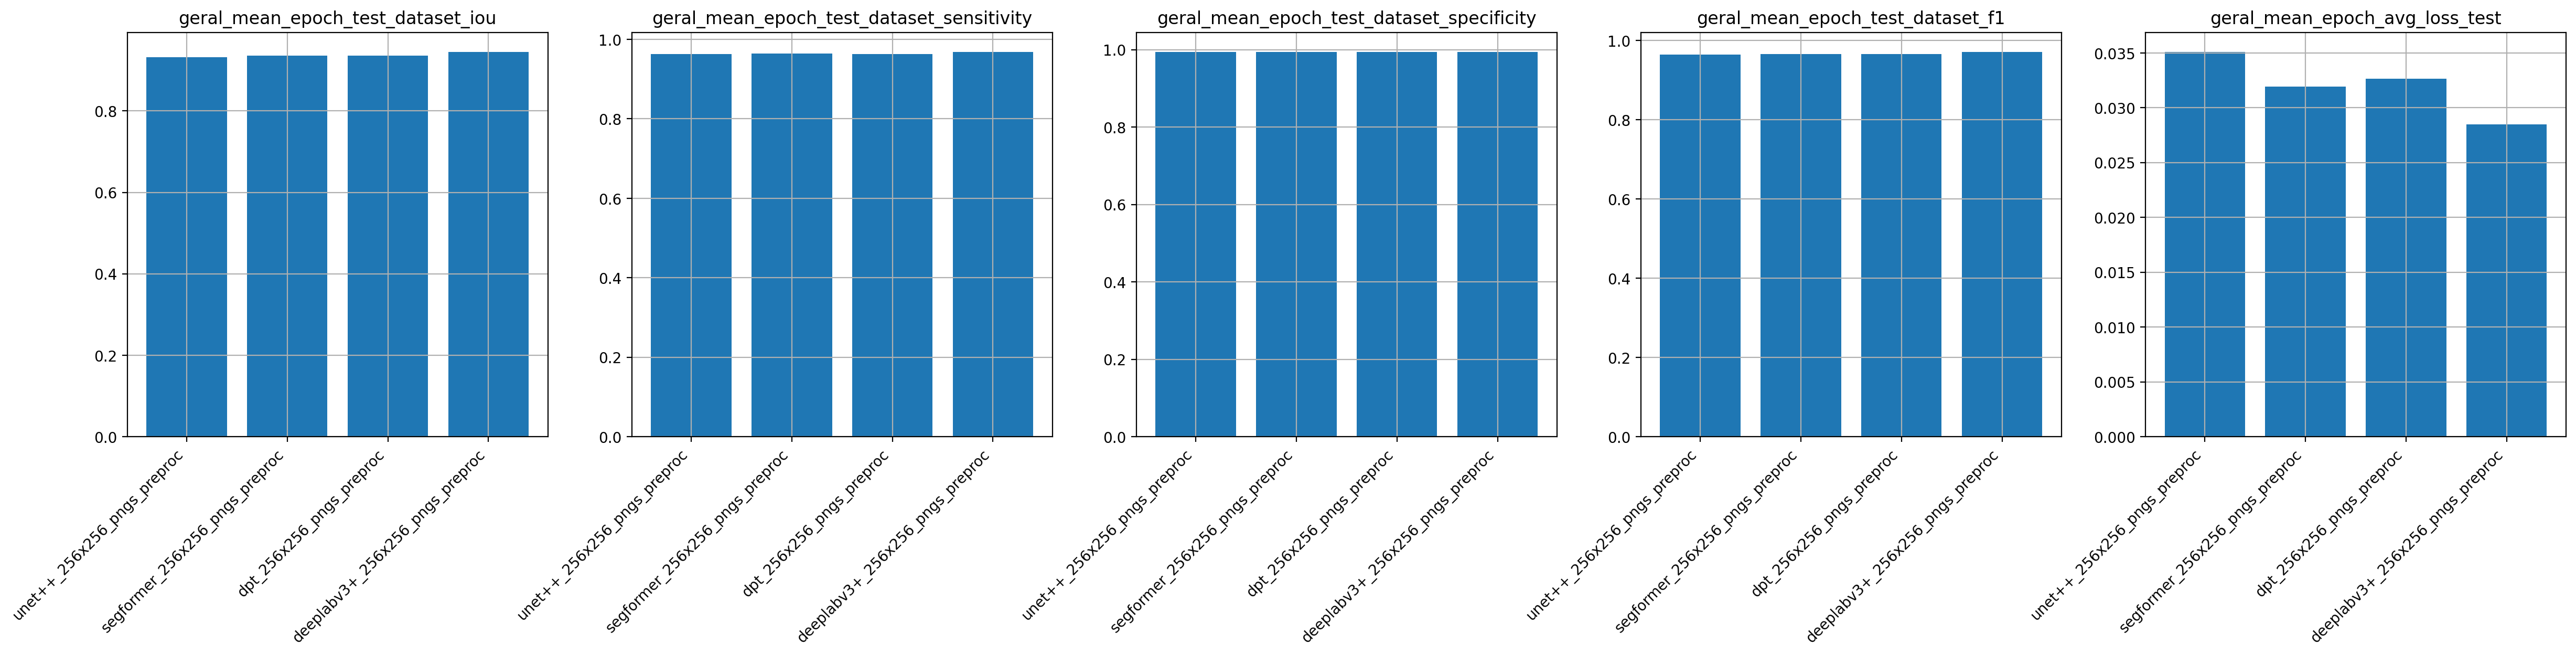

In [178]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5), dpi=200)
# fig.subplots_adjust(hspace=0.5, wspace=0.3)

target_cols = [
    c for c in desempenho_medio_modelos.columns if 'image' not in c and c != 'model' # elimina métricas com redução 'per-image'
]

for i, ax in enumerate(axes.flat[:5]):  # Apenas os primeiros 5 subgráficos
    ax.bar(desempenho_medio_modelos['model'], desempenho_medio_modelos[target_cols[i]])  # Dados aleatórios para o gráfico
    ax.set_title(f"Gráfico {i+1}")

    ax.set_xticks(range(4))
    ax.set_xticklabels(desempenho_medio_modelos['model'], rotation=45, ha="right")
    ax.set_title(target_cols[i])
    ax.grid(True)

In [118]:
df_test

epoch_test_per_image_iou,epoch_test_dataset_iou,epoch_test_per_image_sensitivity,epoch_test_dataset_sensitivity,epoch_test_per_image_specificity,epoch_test_dataset_specificity,epoch_test_per_image_f1,epoch_test_dataset_f1,epoch_avg_loss_test,model,repet,kfolditer
f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i32
0.311821,0.964655,0.317192,0.978925,0.329266,0.994508,0.317538,0.981943,0.017907,"""deeplabv3+_256x256_pngs_prepro…",3,0
0.301495,0.95434,0.313993,0.975734,0.329262,0.995231,0.307346,0.976514,0.026368,"""deeplabv3+_256x256_pngs_prepro…",3,2
0.301112,0.938536,0.309229,0.962461,0.328781,0.993065,0.308547,0.968069,0.035667,"""deeplabv3+_256x256_pngs_prepro…",3,4
0.304892,0.950362,0.312934,0.96991,0.329072,0.993769,0.310918,0.974409,0.02665,"""deeplabv3+_256x256_pngs_prepro…",3,3
0.300347,0.916758,0.312397,0.954581,0.328989,0.993457,0.307038,0.956139,0.037651,"""deeplabv3+_256x256_pngs_prepro…",3,1
…,…,…,…,…,…,…,…,…,…,…,…
0.303163,0.946204,0.313347,0.97169,0.329404,0.994145,0.309885,0.972195,0.027134,"""segformer_256x256_pngs_preproc""",1,0
0.306526,0.949544,0.313097,0.967873,0.329099,0.99388,0.312414,0.973968,0.028361,"""segformer_256x256_pngs_preproc""",1,2
0.301483,0.94316,0.30778,0.962487,0.328274,0.992835,0.308741,0.97056,0.031077,"""segformer_256x256_pngs_preproc""",1,4


#### Shapiro-Wilk

In [4]:
df_test.columns

['epoch_test_per_image_iou',
 'epoch_test_dataset_iou',
 'epoch_test_per_image_sensitivity',
 'epoch_test_dataset_sensitivity',
 'epoch_test_per_image_specificity',
 'epoch_test_dataset_specificity',
 'epoch_test_per_image_f1',
 'epoch_test_dataset_f1',
 'epoch_avg_loss_test',
 'model',
 'repet',
 'kfolditer']

In [6]:
target_cols = [col for col in df_test.columns if 'epoch' in col and 'image' not in col]
target_cols

['epoch_test_dataset_iou',
 'epoch_test_dataset_sensitivity',
 'epoch_test_dataset_specificity',
 'epoch_test_dataset_f1',
 'epoch_avg_loss_test']

In [13]:
from scipy.stats import shapiro, friedmanchisquare

for metric in target_cols:
    print(f'================= {metric} =================')
    for model in df_test['model'].unique():
        print(model)
        df_filtrado = df_test.filter(pl.col('model') == model)
        stat, p_value = shapiro(df_filtrado[metric])

        result = f'Model: {model}\nStat: {stat}\nP-value: {p_value}\n'
        
        if p_value > 0.05:
            print(f'\033[32m{result}\033[0m')
            # print(result)
        else:
            print(result)

================= epoch_test_dataset_iou =================
dpt_256x256_pngs_preproc
Model: dpt_256x256_pngs_preproc
Stat: 0.7765713213798451
P-value: 0.0018686316257746454

deeplabv3+_256x256_pngs_preproc
Model: deeplabv3+_256x256_pngs_preproc
Stat: 0.9067411724301274
P-value: 0.12069397994184411

unet++_256x256_pngs_preproc
Model: unet++_256x256_pngs_preproc
Stat: 0.7642017570446935
P-value: 0.0013231209016900949

segformer_256x256_pngs_preproc
Model: segformer_256x256_pngs_preproc
Stat: 0.8272118723587447
P-value: 0.008396952913892291

================= epoch_test_dataset_sensitivity =================
deeplabv3+_256x256_pngs_preproc
Model: deeplabv3+_256x256_pngs_preproc
Stat: 0.9207350489318505
P-value: 0.19766979174826643

segformer_256x256_pngs_preproc
Model: segformer_256x256_pngs_preproc
Stat: 0.7646635186055848
P-value: 0.0013400893695943476

dpt_256x256_pngs_preproc
Model: dpt_256x256_pngs_preproc
Stat: 0.7935803521864042
P-value: 0.0030447278260622443

unet++_256x256_pngs_pre

#### Friedman

In [28]:
dados_teste_agrupados['epoch_test_dataset_iou', 'model']

data = {}
for model in df_test['model'].unique():
    data[model] = dados_teste_agrupados['epoch_test_dataset_iou', 'model'].filter(pl.col('model') == model)['epoch_test_dataset_iou'].to_numpy()[0]

In [29]:
df = pl.DataFrame(data)
df

deeplabv3+_256x256_pngs_preproc,unet++_256x256_pngs_preproc,segformer_256x256_pngs_preproc,dpt_256x256_pngs_preproc
f64,f64,f64,f64
0.964655,0.94453,0.959435,0.957555
0.95434,0.960809,0.950613,0.861498
0.938536,0.960396,0.958258,0.949448
0.950362,0.953623,0.932168,0.939582
0.916758,0.947676,0.89296,0.906693
…,…,…,…
0.963473,0.943485,0.946204,0.941105
0.932676,0.958042,0.949544,0.935918
0.924764,0.830362,0.94316,0.961948


In [37]:
for metric in target_cols:
    print(f'================= {metric} =================')
    dados_teste_agrupados[metric, 'model']

    data = {}
    for model in df_test['model'].unique():
        data[model] = (
            dados_teste_agrupados[metric, 'model']
            .filter(pl.col('model') == model)[metric]
            .to_numpy()[0]
        )
    print(data)


    stat, p_value = friedmanchisquare(
        data['deeplabv3+_256x256_pngs_preproc'].astype(np.float32),
        data['dpt_256x256_pngs_preproc'].astype(np.float32),
        data['segformer_256x256_pngs_preproc'].astype(np.float32),
        data['unet++_256x256_pngs_preproc'].astype(np.float32))


    result = f'RESULTADO (Friedman):\n\nStat: {stat}\nP-value: {p_value}\n'

    if p_value > 0.05:
        print(f'\033[32m{result}\033[0m')
        # print(result)
    else:
        print(result)

================= epoch_test_dataset_iou =================
{'deeplabv3+_256x256_pngs_preproc': array([0.96465486, 0.9543401 , 0.93853647, 0.95036161, 0.91675848,
       0.96259701, 0.96004939, 0.94134438, 0.96066403, 0.91462827,
       0.96347314, 0.93267596, 0.92476356, 0.95164454, 0.94503284]), 'segformer_256x256_pngs_preproc': array([0.95943534, 0.95061255, 0.95825779, 0.93216848, 0.89295977,
       0.9559257 , 0.96527737, 0.95429265, 0.92347193, 0.91659874,
       0.94620407, 0.94954407, 0.94316041, 0.93392491, 0.85670793]), 'unet++_256x256_pngs_preproc': array([0.94452965, 0.96080941, 0.96039641, 0.95362318, 0.9476763 ,
       0.93871301, 0.95593512, 0.95321691, 0.89050233, 0.91524589,
       0.94348538, 0.95804238, 0.83036172, 0.92069817, 0.91705525]), 'dpt_256x256_pngs_preproc': array([0.95755476, 0.86149788, 0.94944757, 0.93958169, 0.90669334,
       0.94213951, 0.95893228, 0.95979464, 0.95478785, 0.88004464,
       0.94110519, 0.93591815, 0.96194828, 0.93726027, 0.95059592])}


### Diferenças entre modelos

In [33]:
# import scikit_posthocs as sp
# import pandas as pd

# df = pd.DataFrame(data)

# sp.posthoc_nemenyi_friedman(df)